In [1]:
%load_ext autoreload
%autoreload 1
%aimport functions.helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, make_scorer
from functions.helpers import convert_feature_types

/home/estacio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Dataset reference: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success
- Competition site: https://www.kaggle.com/competitions/playground-series-s4e6/overview

# Load dataset

In [2]:
df = pd.read_csv('./datasets/train.csv', index_col='id')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


# Original data

In [3]:
df_og = pd.read_csv('datasets/original_data.csv', sep=';')

In [5]:
df_og.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [6]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [4]:
df_concat = pd.concat([df, df_og])
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80942 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  80942 non-null  int64  
 1   Application mode                                80942 non-null  int64  
 2   Application order                               80942 non-null  int64  
 3   Course                                          80942 non-null  int64  
 4   Daytime/evening attendance                      80942 non-null  int64  
 5   Previous qualification                          80942 non-null  int64  
 6   Previous qualification (grade)                  80942 non-null  float64
 7   Nacionality                                     80942 non-null  int64  
 8   Mother's qualification                          80942 non-null  int64  
 9   Father's qualification                       

In [67]:
df_concat.tail()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate
4423,1,10,1,9773,1,1,152.0,22,38,37,...,0,6,6,6,13.000000,0,12.7,3.7,-1.70,Graduate


In [5]:
df_concat.reset_index(drop=True, inplace=True)

In [70]:
df_concat.tail()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
80937,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
80938,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
80939,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
80940,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate
80941,1,10,1,9773,1,1,152.0,22,38,37,...,0,6,6,6,13.000000,0,12.7,3.7,-1.70,Graduate


In [6]:
df = df_concat.copy()
df = convert_feature_types(df)

In [7]:
y = df['Target']
X = df.drop(['Target'], axis=1)
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,0,6,7,6,12.428571,0,11.1,0.6,2.02
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,0,6,9,0,0.000000,0,11.1,0.6,2.02
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,0,8,11,7,12.820000,0,11.1,0.6,2.02
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,0,7,12,6,12.933333,0,7.6,2.6,0.32


# Data Exploration

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80942 entries, 0 to 80941
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  80942 non-null  category
 1   Application mode                                80942 non-null  category
 2   Application order                               80942 non-null  category
 3   Course                                          80942 non-null  category
 4   Daytime/evening attendance                      80942 non-null  category
 5   Previous qualification                          80942 non-null  category
 6   Previous qualification (grade)                  80942 non-null  float64 
 7   Nacionality                                     80942 non-null  category
 8   Mother's qualification                          80942 non-null  category
 9   Father's qualification      

In [10]:
# valores faltantes
df.isnull().sum().sum()

0

### Variáveis
- Marital Status: numbers -> Transform into categorical var
- Application mode: numbers -> Transform into categorical var
- Course: numbers -> Transform into categorical var
- Daytime/evening attendance -> transform into categorical var
- Previous qualification -> transform into categorical var
- previous qualification (grade) -> looks like numerical
- Nacionality -> transform into categorical var
- Mother's qualification -> transform into cat var
- Father's qualification -> transform into cat var
- Mother's occupation -> transform into cat var
- Father's occupation -> transform into cat var
- Addmission grade -> looks numericals
- Displaced -> transform into binary var
- Educational special needs -> binary var
- Debtor -> binary var
- Tuition fees up to date -> binary var
- Gender -> binary var
- Scholarship holder -> binary var
- Age at enrollment -> numerical var (ok)
- International -> binary var
- Curricular units -> I'm not sure what this is.

In [4]:
df.dtypes

Marital status                                    category
Application mode                                  category
Application order                                 category
Course                                            category
Daytime/evening attendance                        category
Previous qualification                            category
Previous qualification (grade)                     float64
Nacionality                                       category
Mother's qualification                            category
Father's qualification                            category
Mother's occupation                               category
Father's occupation                               category
Admission grade                                    float64
Displaced                                         category
Educational special needs                         category
Debtor                                            category
Tuition fees up to date                           catego

<Axes: xlabel='Target', ylabel='count'>

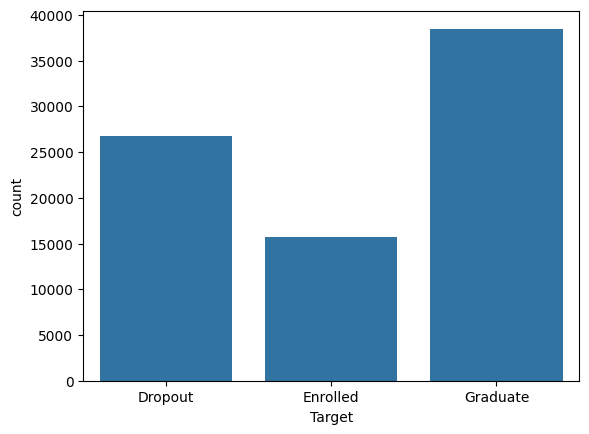

In [23]:
sns.barplot(y.value_counts())

### Comparison between train and test datasets

In [24]:
df_train =  df.copy()
df_test = pd.read_csv('datasets/test.csv')

In [25]:
df_test['dataset'] = ['test']*len(df_test)

In [26]:
df_train['dataset'] = ['train']*len(df_train)

In [27]:
df_complete = pd.concat([df_train, df_test])
df_complete.drop('Target', axis=1, inplace=True)

In [29]:
df_complete = convert_feature_types(df_complete)
num_variables = df_complete.select_dtypes(include=['float64']).columns.tolist()

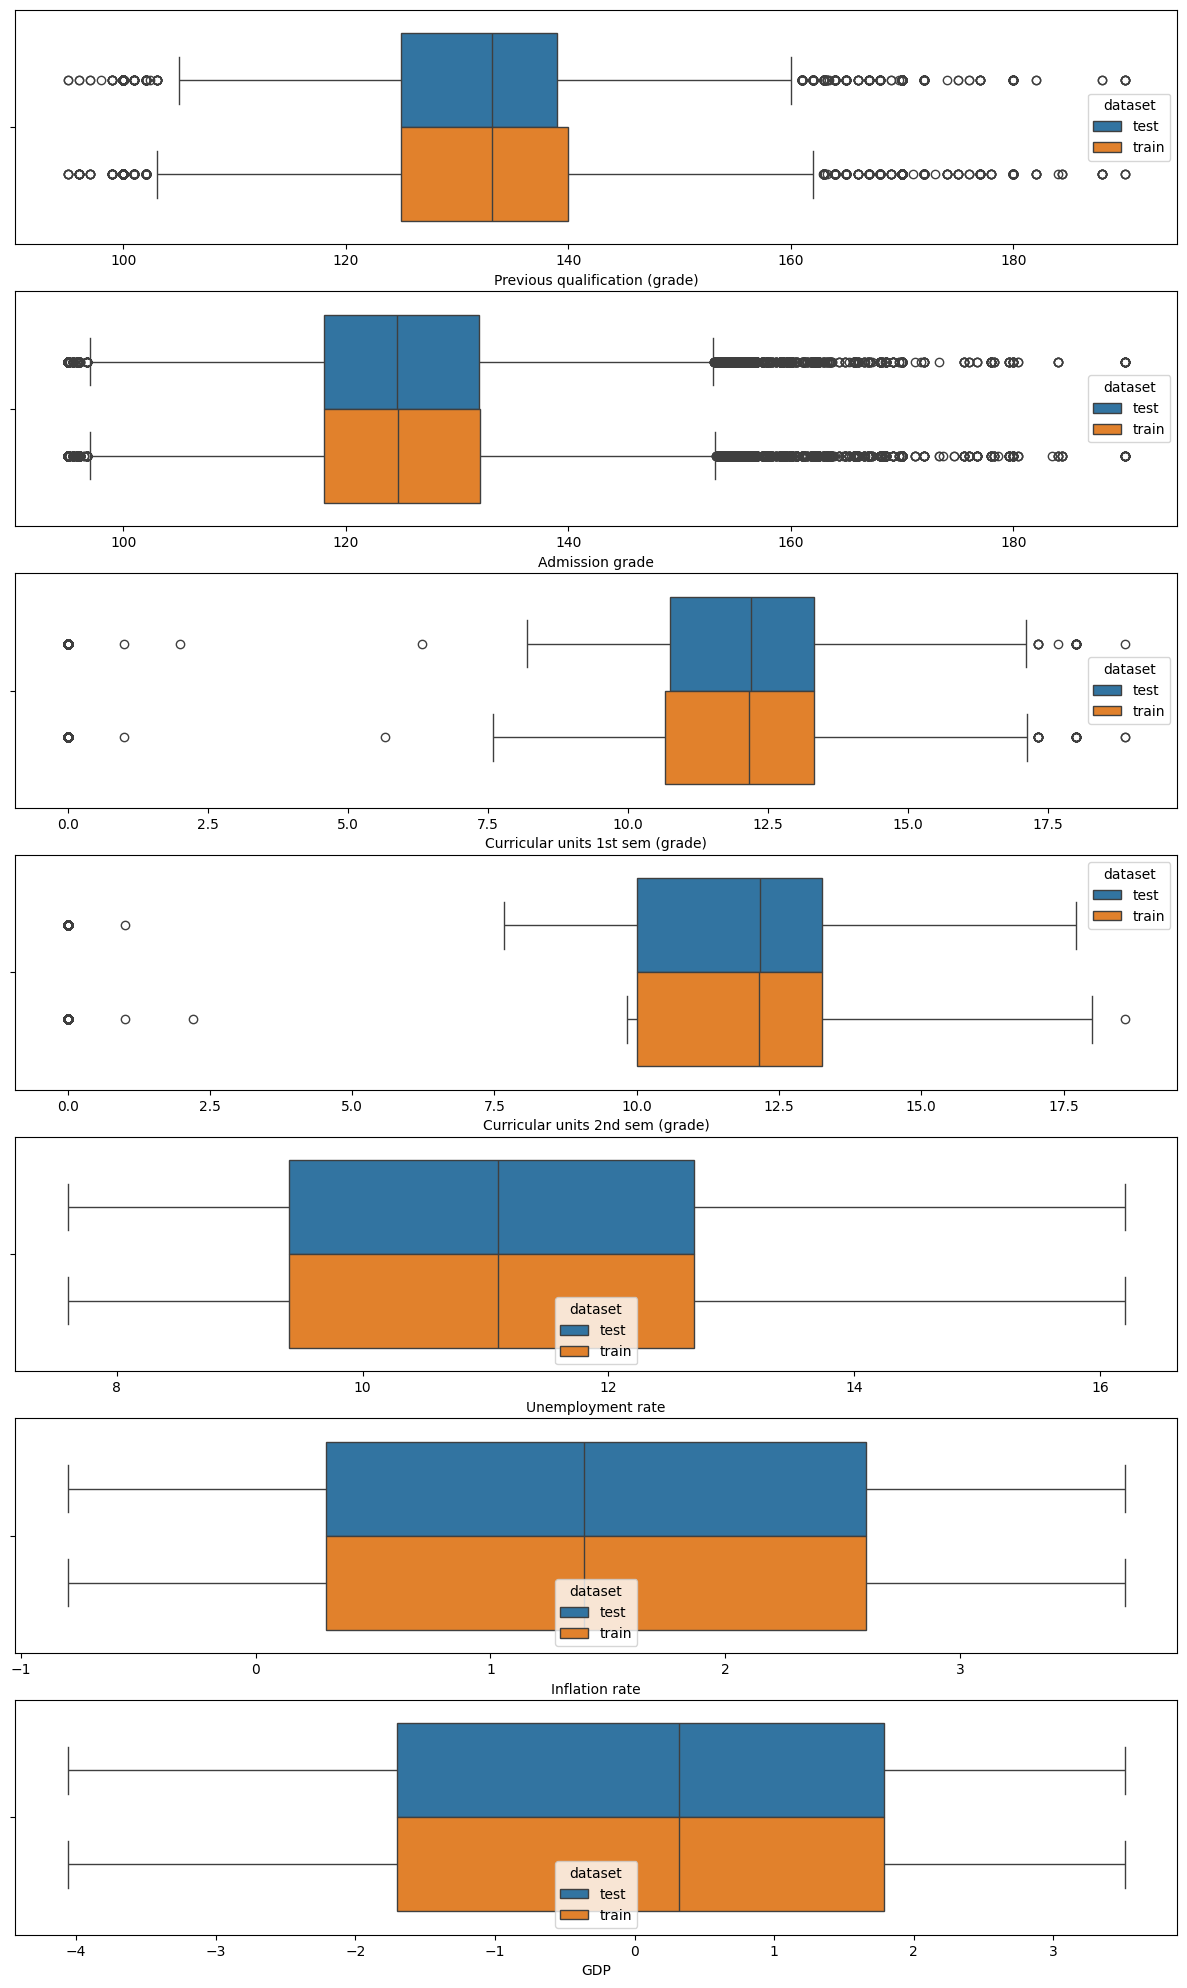

In [30]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i])

They all seem very similar with the exception of 'Curricular units 2nd sem (grade)' whose 25 percentil is higher in train than in test.

In [ ]:
num_variables = df_complete.select_dtypes(include=['float64']).columns.tolist()

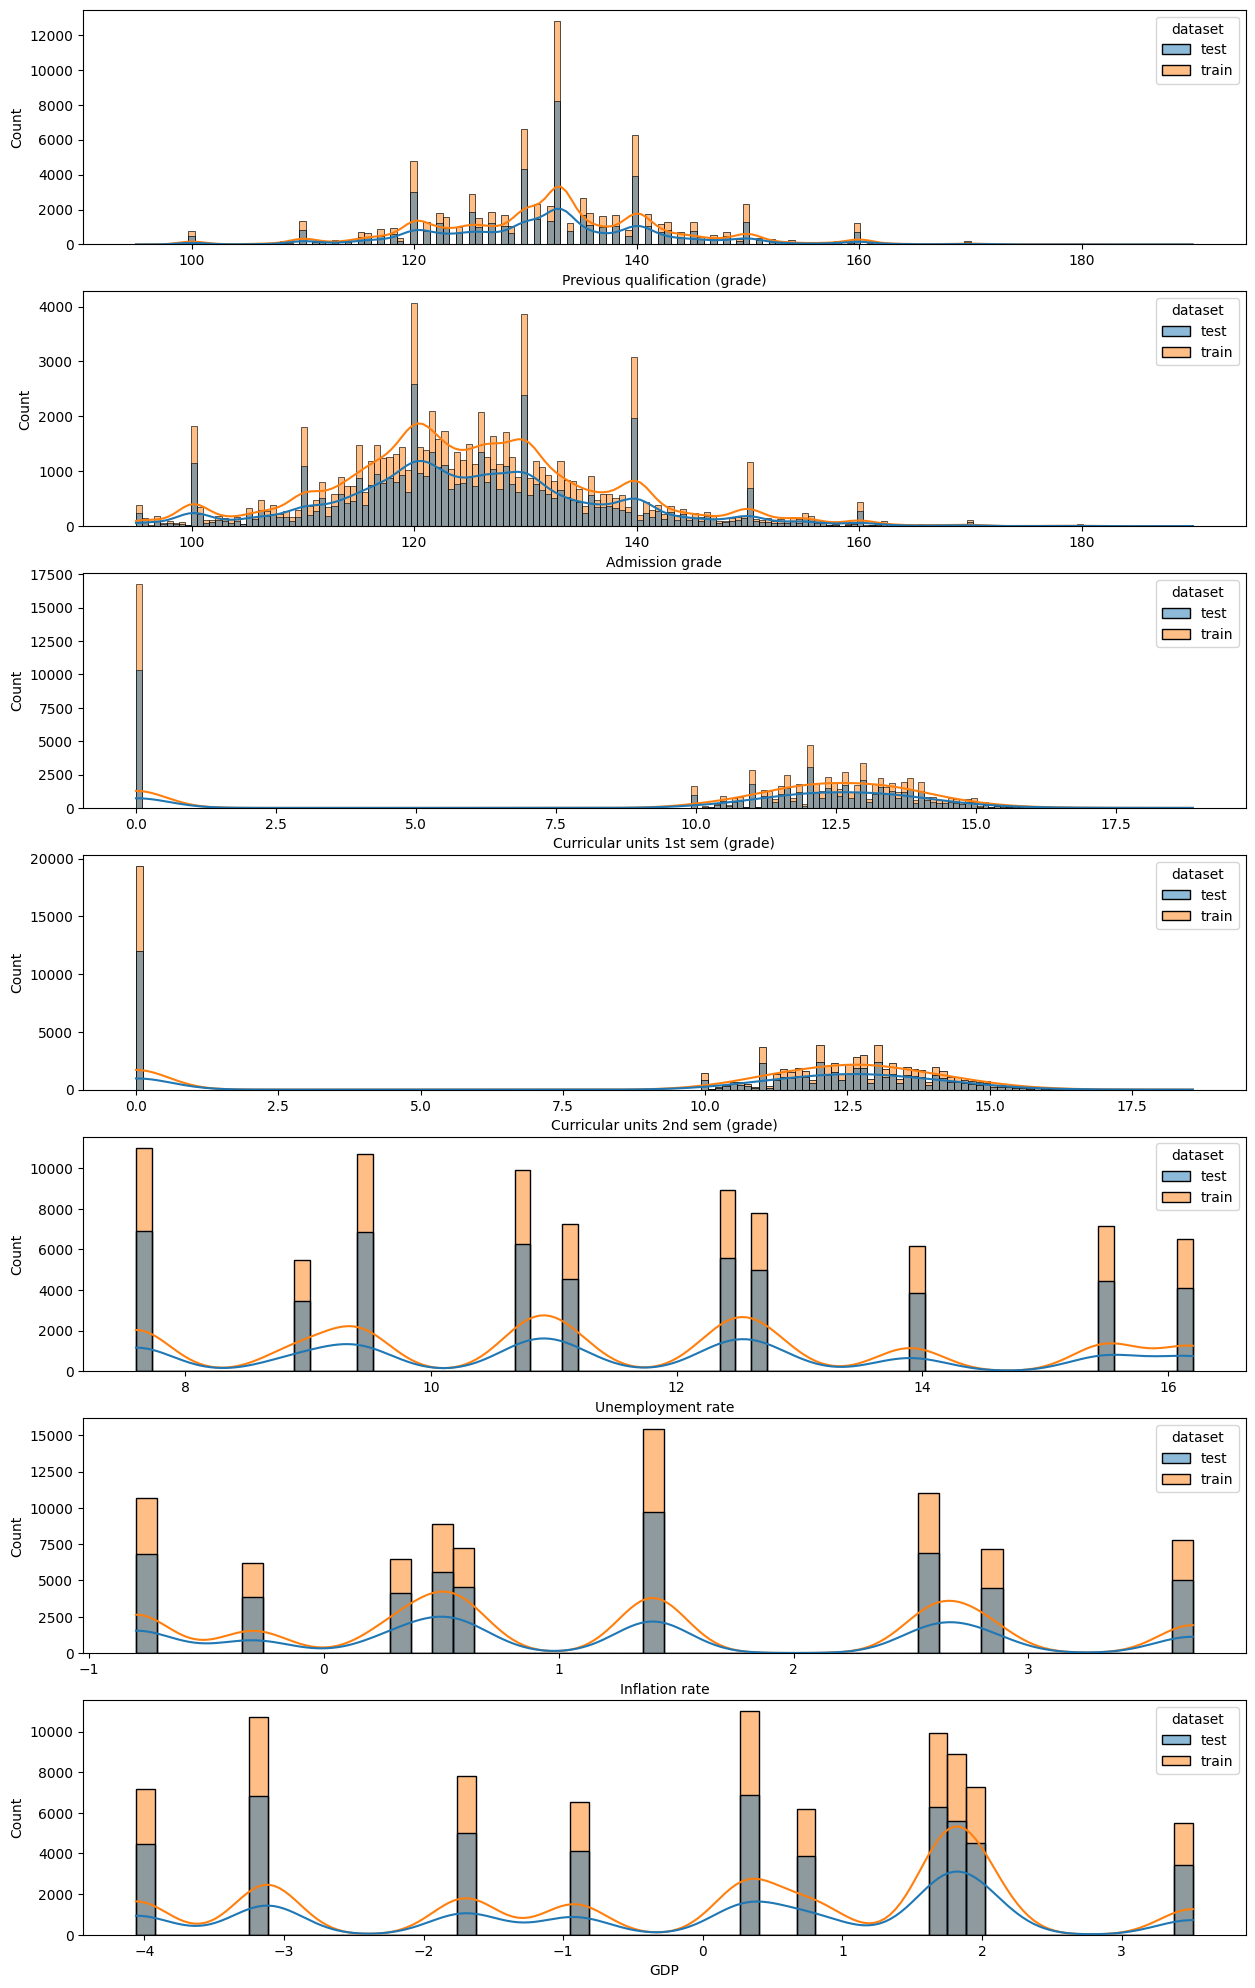

In [31]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.histplot(data=df_complete, x=num_variables[i], hue='dataset', ax=axes[i], kde=True)

They all look similar.

### Check boxplots of numerical variables versus the target variable

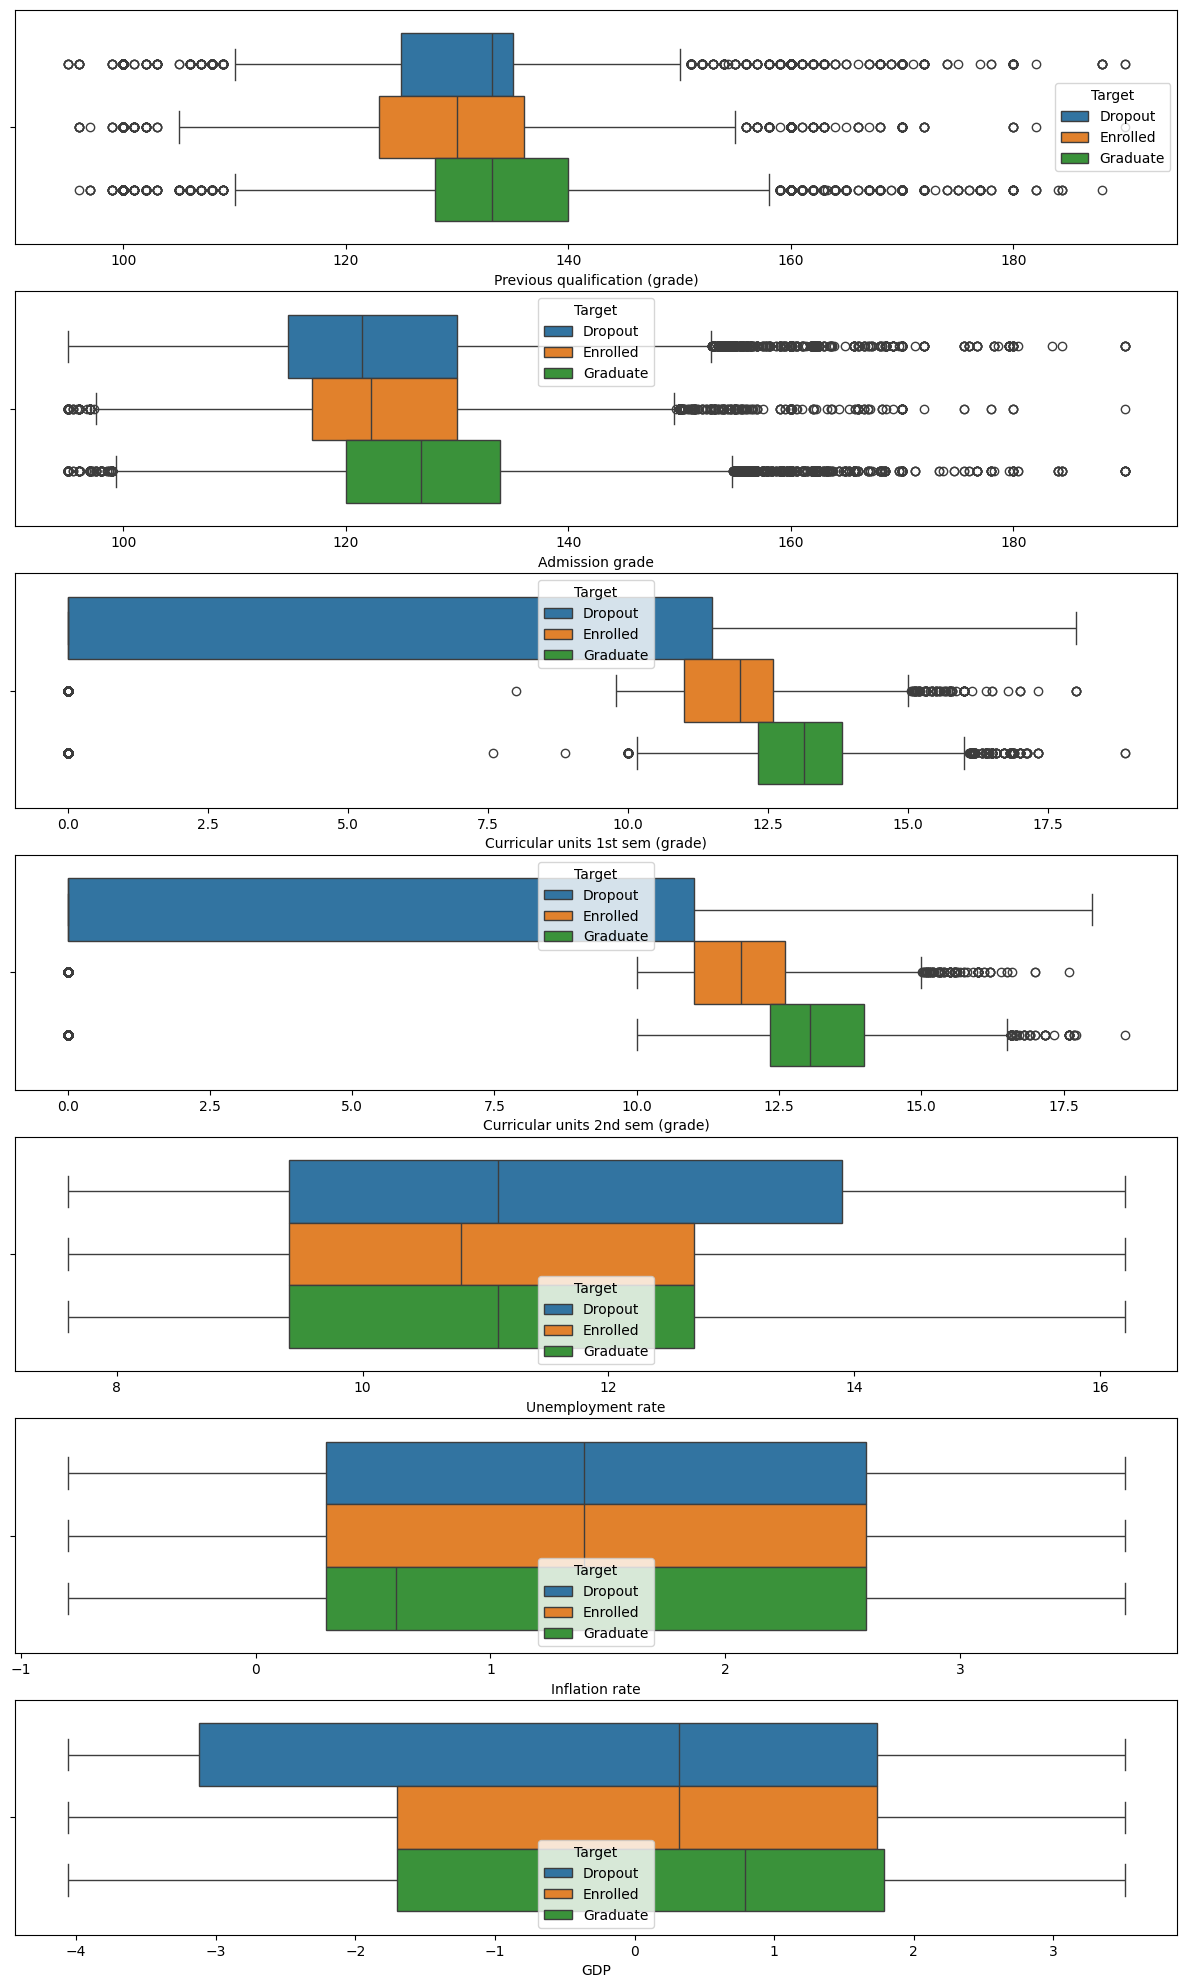

In [33]:
fig, axes = plt.subplots(nrows = len(num_variables), ncols=1, figsize=(15,25))
for i in range(len(num_variables)):
    sns.boxplot(data=df, x=num_variables[i], hue='Target', ax=axes[i])

<Axes: >

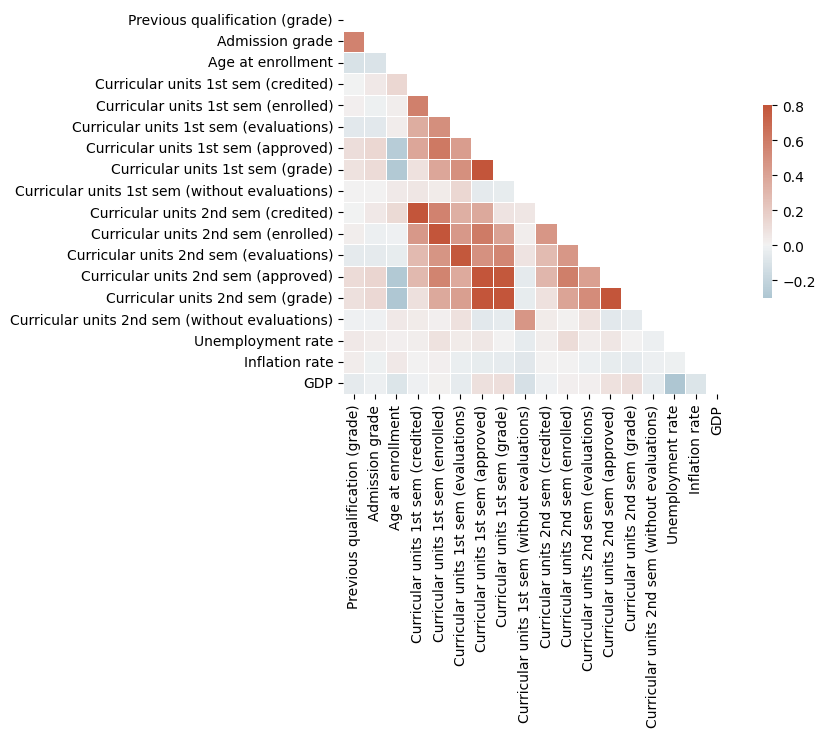

In [34]:
num_variables = df_complete.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr = df[num_variables].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(9,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, vmax=0.8, center=0, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [65]:
df[df['Curricular units 1st sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     14857
Enrolled      635
Graduate      550
Name: count, dtype: int64

In [69]:
df[df['Curricular units 1st sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35732
Enrolled    14305
Dropout     10439
Name: count, dtype: int64

In [71]:
14857/(14857+635+550) # dropout

0.926131405061713

In [73]:
(35732+14306)/(14305+10439+35732) # enrolled + graduate

0.8274026059924598

In [67]:
df[df['Curricular units 2nd sem (grade)'] < 10.0]['Target'].value_counts()

Target
Dropout     17259
Enrolled      669
Graduate      555
Name: count, dtype: int64

In [70]:
df[df['Curricular units 2nd sem (grade)'] >= 10.0]['Target'].value_counts()

Target
Graduate    35727
Enrolled    14271
Dropout      8037
Name: count, dtype: int64

In [68]:
17259/(17259+669+555)

0.9337769842558026

The average grades of each semester look like a very good indicator of droupouts.

Would it be benefitial the creation of a binary variable of "Grades >= 10.0"?

# Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [9]:
cat_variables = df.drop('Target', axis=1).select_dtypes(include=['category', 'bool']).columns.to_list()
num_variables = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [10]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_variables),
    ('num', StandardScaler(), num_variables)
])

X_trans = ct.fit_transform(X)

In [11]:
col_names = ct.named_transformers_['cat'].get_feature_names_out().tolist()+ct.named_transformers_['num'].get_feature_names_out().tolist()
X_trans = pd.DataFrame.sparse.from_spmatrix(X_trans, columns=col_names)

In [14]:
X_trans.head()

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_4,Application mode_5,Application mode_7,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0,0,0,0,0,0,0,0,0,0,...,-0.145215,-0.156539,0.030191,-0.07917,0.706279,0.500819,-0.139217,-0.159327,-0.449386,0.930716
1,0,0,0,0,0,0,0,0,0,0,...,-0.145215,-0.156539,0.030191,0.486796,-1.445509,-1.746712,-0.139217,-0.159327,-0.449386,0.930716
2,0,0,0,0,0,0,0,0,0,0,...,-0.145215,-0.156539,0.030191,-2.060049,-1.445509,-1.746712,-0.139217,1.762347,-0.66399,-0.37453
3,0,0,0,0,0,0,0,0,0,0,...,-0.145215,-0.156539,1.231639,1.052762,1.06491,0.571603,-0.139217,-0.159327,-0.449386,0.930716
4,0,0,0,0,0,0,0,0,0,0,...,-0.145215,-0.156539,0.630915,1.335744,0.706279,0.592098,-0.139217,-1.478123,0.981307,0.175982


# Feature Selection

In [12]:
remove_cols = ['Application mode_4', 'Application mode_9', 'Application mode_12',
       'Application mode_26', 'Course_39', 'Course_979',
       'Previous qualification_36', 'Previous qualification_37',
       'Nacionality_17', "Mother's qualification_7",
       "Mother's qualification_8", "Mother's qualification_15",
       "Mother's qualification_27", "Mother's qualification_28",
       "Father's qualification_15", "Father's qualification_20",
       "Father's qualification_23", "Father's qualification_24",
       "Father's qualification_44", "Mother's occupation_11",
       "Mother's occupation_38", "Mother's occupation_101",
       "Mother's occupation_103", "Mother's occupation_127",
       "Mother's occupation_163", "Mother's occupation_172",
       "Father's occupation_12", "Father's occupation_13",
       "Father's occupation_19", "Father's occupation_22",
       "Father's occupation_39", "Father's occupation_96",
       "Father's occupation_132", "Father's occupation_148",
       "Father's occupation_191"]

In [13]:
X_trans.drop(remove_cols, axis=1, inplace=True)

# Outliers

## Isolation Forest

In [12]:
clf = IsolationForest(random_state=42).fit(X_trans)
outliers =  clf.predict(X_trans)

In [13]:
np.sum(outliers == -1)

70

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

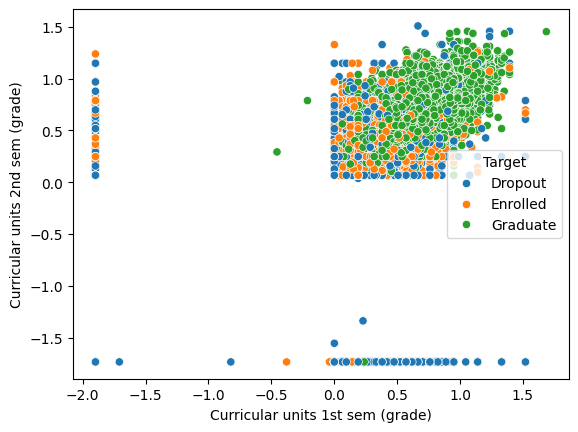

In [14]:
sns.scatterplot(data=X_trans, x='Curricular units 1st sem (grade)', y='Curricular units 2nd sem (grade)', hue=y)

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

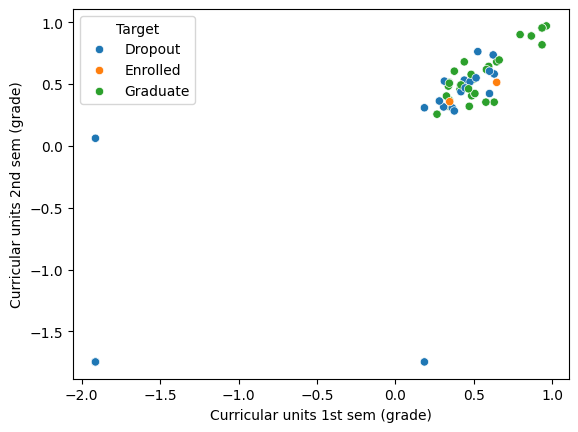

In [95]:
sns.scatterplot(data=X_trans.loc[outliers==-1], 
                x='Curricular units 1st sem (grade)', 
                y='Curricular units 2nd sem (grade)',
                hue=y.loc[outliers==-1])

## Local Outline Factor

In [38]:
from sklearn.neighbors import LocalOutlierFactor

In [39]:
lof = LocalOutlierFactor()
lof_outliers = lof.fit_predict(X_trans)

In [40]:
np.sum(lof_outliers==-1)

261

In [41]:
np.sum(lof_outliers==1)

76257

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

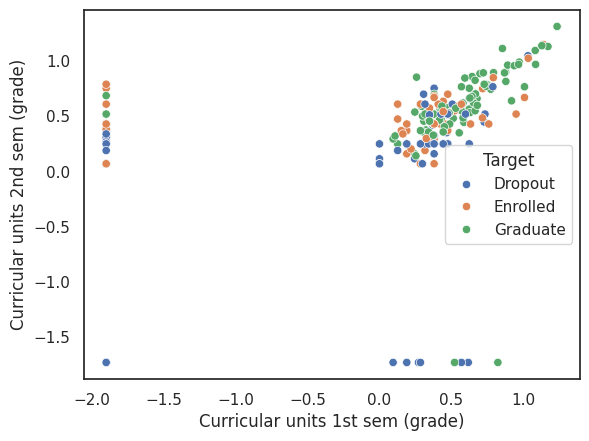

In [42]:
sns.scatterplot(data=X_trans.loc[lof_outliers==-1], 
                x='Curricular units 1st sem (grade)', 
                y='Curricular units 2nd sem (grade)',
                hue=y.loc[lof_outliers==-1])

In [24]:
X_trans.drop(X_trans.loc[lof_outliers == -1].index, inplace=True)

# Optuna

In [164]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create a RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    kf = KFold(n_splits=5)
    acc = [] 

    # Train the model
    for i, (train_index, test_index) in enumerate(kf.split(X_trans)):
        print(f'Kfold: {i}')
        clf.fit(X_trans.iloc[train_index], y[train_index])
        y_pred = clf.predict(X_trans.iloc[test_index])
        acc.append(accuracy_score(y[test_index], y_pred))
    
    # Calculate accuracy
    accuracy = np.mean(acc)
    
    return accuracy


In [ ]:
# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding accuracy
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)


# AutoGluon

In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [20]:
# AutoGluon does its own preprocessing, therefore I don't need to pass my version of the dataset preprocessed.
#df_autogluon = df.drop(df.loc[outliers == -1].index)
df_autogluon = X_trans.copy()
df_autogluon['Target'] = df['Target']
#df_autogluon = TabularDataset(df.drop(df.loc[outliers == -1].index))
df_autogluon.tail()

,Marital status_2,Marital status_3,Marital status_4,Marital status_5,Marital status_6,Application mode_2,Application mode_3,Application mode_5,Application mode_7,Application mode_10,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
80937,0,0,0,0,0,0,0,0,0,0,...,-0.156539,0.030191,0.203813,0.347647,0.543875,-0.139217,1.498588,1.124376,-1.768567,Graduate
80938,0,0,0,0,0,0,0,0,0,0,...,-0.156539,0.030191,-0.362152,-0.728246,0.242482,-0.139217,-0.159327,-0.449386,0.930716,Dropout
80939,0,0,0,0,0,0,0,0,0,0,...,-0.156539,1.231639,0.486796,-1.086877,0.694571,-0.139217,0.89571,-1.093198,0.384644,Dropout
80940,0,0,0,0,0,0,0,0,0,0,...,-0.156539,-0.570532,-0.362152,0.347647,0.423318,-0.139217,-0.799885,-1.450872,-1.351244,Graduate
80941,0,0,0,0,0,0,0,0,0,1.0,...,-0.156539,0.030191,-0.362152,0.706279,0.604154,-0.139217,0.443551,1.768188,-0.720819,Graduate


In [22]:
predictor = TabularPredictor(label='Target', eval_metric='accuracy').fit(df_autogluon, time_limit=7200, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240628_172855"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #41~22.04.2-Ubuntu SMP PREEMPT_DYNAMIC Mon Jun  3 11:32:55 UTC 2
CPU Count:          12
Memory Avail:       3.38 GB / 7.46 GB (45.3%)
Disk Space Avail:   400.37 GB / 467.35 GB (85.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of Auto

(_ray_fit pid=14027) [1000]	valid_set's multi_error: 0.171781
(_ray_fit pid=14025) [1000]	valid_set's multi_error: 0.171448 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=14025) [2000]	valid_set's multi_error: 0.169224


(_dystack pid=9371) 	0.8305	 = Validation score   (accuracy)
(_dystack pid=9371) 	57.86s	 = Training   runtime
(_dystack pid=9371) 	24.23s	 = Validation runtime
(_dystack pid=9371) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 823.54s of the 1421.73s of remaining time.
(_dystack pid=9371) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=6.27%)
(_dystack pid=9371) 	Warning: Exception caused NeuralNetFastAI_r191_BAG_L1 to fail during training... Skipping this model.
(_dystack pid=9371) 		ray::_ray_fit() (pid=14389, ip=192.168.0.153)
(_dystack pid=9371)   File "/home/estacio/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 402, in _ray_fit
(_dystack pid=9371)     fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
(_dystack pid=9371)   File "/home/estacio/.local/li

(_ray_fit pid=15423) [1000]	valid_set's multi_error: 0.172782
(_ray_fit pid=15423) [2000]	valid_set's multi_error: 0.172115 [repeated 7x across cluster]
(_ray_fit pid=15426) [3000]	valid_set's multi_error: 0.16902 [repeated 3x across cluster]


(_dystack pid=9371) 	0.8293	 = Validation score   (accuracy)
(_dystack pid=9371) 	80.49s	 = Training   runtime
(_dystack pid=9371) 	34.63s	 = Validation runtime
(_dystack pid=9371) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 460.85s of the 1059.03s of remaining time.
(_dystack pid=9371) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=4.40%)
(_dystack pid=9371) 	Warning: Exception caused NeuralNetTorch_r22_BAG_L1 to fail during training... Skipping this model.
(_dystack pid=9371) 		ray::_ray_fit() (pid=16646, ip=192.168.0.153)
(_dystack pid=9371)   File "/home/estacio/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 402, in _ray_fit
(_dystack pid=9371)     fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
(_dystack pid=9371)   File "/home/estacio/.local/lib/py

(raylet) The node with node id: f917e8465b02e9098ec88257a55f3369fcf13bd28c4ec5dd03d42d89 and address: 192.168.0.153 and node name: 192.168.0.153 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.
(raylet) Raylet is terminated. Termination is unexpected. Possible reasons include: (1) SIGKILL by the user or system OOM killer, (2) Invalid memory access from Raylet causing SIGSEGV or SIGBUS, (3) Other termination signals. Last 20 lines of the Raylet logs:
    [2024-06-29 10:59:57,618 W 9303 9303] (raylet) memory_monitor.cc:197: Got negative used memory for cgroup -1, setting it to zero
    [2024-06-29 10:59:58,224 I 9303 9303] (raylet) accessor.cc:627: Received notification for node id = f917e8465b02e9098ec88257a55f3369fcf13bd28c4ec5dd03d42d89, IsAlive = 0
    [2024-06-29 10:59:58,245 C 9303 9303] (rayle

In [23]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.834054,accuracy,80.602611,1010.447087,0.005491,3.213262,2,True,39
1,XGBoost_r89_BAG_L2,0.834054,accuracy,330.605815,3380.326473,0.698737,26.595172,2,True,59
2,WeightedEnsemble_L3,0.834054,accuracy,330.610894,3383.603195,0.005079,3.276721,3,True,66
3,XGBoost_BAG_L2,0.833622,accuracy,330.592802,3385.281737,0.685723,31.550436,2,True,47
4,CatBoost_r50_BAG_L2,0.833597,accuracy,329.976299,3375.397867,0.069220,21.666566,2,True,61
...,...,...,...,...,...,...,...,...,...,...
61,ExtraTreesGini_BAG_L1,0.819550,accuracy,2.935551,7.837274,2.935551,7.837274,1,True,8
62,ExtraTrees_r49_BAG_L1,0.819315,accuracy,2.356700,6.477294,2.356700,6.477294,1,True,37
63,ExtraTreesEntr_BAG_L1,0.819192,accuracy,3.000413,8.026878,3.000413,8.026878,1,True,9
64,KNeighborsDist_BAG_L1,0.772714,accuracy,4.832809,0.038772,4.832809,0.038772,1,True,2


In [77]:
predictor.model_best

'WeightedEnsemble_L2'

In [23]:
predictor.feature_importance(df_autogluon)

Computing feature importance via permutation shuffling for 35 features using 5000 rows with 5 shuffle sets...
	19.28s	= Expected runtime (3.86s per shuffle set)
	9.97s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.20452,0.007901,2.668018e-07,5,0.220789,0.188251
Tuition fees up to date,0.04068,0.004093,1.213254e-05,5,0.049107,0.032253
Curricular units 1st sem (approved),0.03556,0.004834,3.999001e-05,5,0.045513,0.025607
Course,0.02136,0.001126,9.234368e-07,5,0.023679,0.019041
Curricular units 2nd sem (evaluations),0.01188,0.004239,1.654807e-03,5,0.020609,0.003151
Scholarship holder,0.00820,0.001828,2.774528e-04,5,0.011963,0.004437
Curricular units 1st sem (grade),0.00408,0.001397,1.420611e-03,5,0.006957,0.001203
Mother's occupation,0.00404,0.002512,1.141118e-02,5,0.009211,-0.001131
Father's occupation,0.00368,0.002678,1.859845e-02,5,0.009194,-0.001834
Curricular units 1st sem (evaluations),0.00356,0.002224,1.159774e-02,5,0.008140,-0.001020


# Ensemble

In [15]:
predictor = TabularPredictor.load('AutogluonModels/ag-20240628_172855')

In [16]:
predictor.model_names()

['KNeighborsUnif_BAG_L1',
 'KNeighborsDist_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBM_BAG_L1',
 'RandomForestGini_BAG_L1',
 'RandomForestEntr_BAG_L1',
 'CatBoost_BAG_L1',
 'ExtraTreesGini_BAG_L1',
 'ExtraTreesEntr_BAG_L1',
 'XGBoost_BAG_L1',
 'LightGBMLarge_BAG_L1',
 'CatBoost_r177_BAG_L1',
 'LightGBM_r131_BAG_L1',
 'CatBoost_r9_BAG_L1',
 'LightGBM_r96_BAG_L1',
 'XGBoost_r33_BAG_L1',
 'ExtraTrees_r42_BAG_L1',
 'CatBoost_r137_BAG_L1',
 'CatBoost_r13_BAG_L1',
 'RandomForest_r195_BAG_L1',
 'LightGBM_r188_BAG_L1',
 'XGBoost_r89_BAG_L1',
 'LightGBM_r130_BAG_L1',
 'CatBoost_r50_BAG_L1',
 'XGBoost_r194_BAG_L1',
 'ExtraTrees_r172_BAG_L1',
 'CatBoost_r69_BAG_L1',
 'LightGBM_r161_BAG_L1',
 'CatBoost_r70_BAG_L1',
 'LightGBM_r196_BAG_L1',
 'RandomForest_r39_BAG_L1',
 'CatBoost_r167_BAG_L1',
 'XGBoost_r98_BAG_L1',
 'LightGBM_r15_BAG_L1',
 'CatBoost_r86_BAG_L1',
 'CatBoost_r49_BAG_L1',
 'ExtraTrees_r49_BAG_L1',
 'LightGBM_r143_BAG_L1',
 'WeightedEnsemble_L2',
 'LightGBMXT_BAG_L2',
 'LightGBM_BAG_L2',

In [18]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.834054,accuracy,80.602611,1010.447087,0.005491,3.213262,2,True,39
1,XGBoost_r89_BAG_L2,0.834054,accuracy,330.605815,3380.326473,0.698737,26.595172,2,True,59
2,WeightedEnsemble_L3,0.834054,accuracy,330.610894,3383.603195,0.005079,3.276721,3,True,66
3,XGBoost_BAG_L2,0.833622,accuracy,330.592802,3385.281737,0.685723,31.550436,2,True,47
4,CatBoost_r50_BAG_L2,0.833597,accuracy,329.976299,3375.397867,0.069220,21.666566,2,True,61
...,...,...,...,...,...,...,...,...,...,...
61,ExtraTreesGini_BAG_L1,0.819550,accuracy,2.935551,7.837274,2.935551,7.837274,1,True,8
62,ExtraTrees_r49_BAG_L1,0.819315,accuracy,2.356700,6.477294,2.356700,6.477294,1,True,37
63,ExtraTreesEntr_BAG_L1,0.819192,accuracy,3.000413,8.026878,3.000413,8.026878,1,True,9
64,KNeighborsDist_BAG_L1,0.772714,accuracy,4.832809,0.038772,4.832809,0.038772,1,True,2


In [21]:
ans = predictor.predict_proba(df_autogluon, model='WeightedEnsemble_L2')

In [22]:
ans

,Dropout,Enrolled,Graduate
0,0.012477,0.029966,0.957557
1,0.905029,0.077328,0.017643
2,0.967166,0.020202,0.012632
3,0.034464,0.352605,0.612931
4,0.046772,0.380512,0.572716
...,...,...,...
80937,0.153410,0.337561,0.509029
80938,0.944963,0.040868,0.014169
80939,0.637575,0.104533,0.257892
80940,0.024387,0.066937,0.908676


# Submission

In [79]:
df_test = pd.read_csv('./datasets/test.csv')
df_test = convert_feature_types(df_test)
id = df_test.pop('id')
#df_test = predictor.transform_features(df_test)
#df_test = ct.transform(df_test)
#df_test = pd.DataFrame.sparse.from_spmatrix(df_test, columns=col_names)
#df_test.drop(remove_cols, axis=1, inplace=True)


In [50]:
df_test

,Daytime/evening attendance,Previous qualification (grade),Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,...,Marital status,Application mode,Application order,Course,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation
0,0,141.0,152.1,0,0,0,1,0,1,18,...,0,0,1,11,0,0,2,0,2,3
1,0,128.0,116.5,0,0,0,0,0,1,19,...,0,0,1,9,0,0,0,14,4,5
2,0,118.0,114.2,0,0,0,0,0,0,18,...,0,0,1,9,0,0,0,14,4,9
3,0,130.0,130.0,0,0,0,0,0,0,23,...,0,13,1,8,16,0,0,14,3,3
4,0,110.0,106.0,1,0,0,0,0,1,26,...,0,10,1,13,0,0,0,24,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51007,0,128.0,124.7,1,0,0,0,0,1,19,...,0,0,2,1,0,0,22,24,7,10
51008,0,133.1,140.0,0,0,1,1,1,1,33,...,1,10,1,6,13,0,12,24,9,9
51009,0,127.0,120.4,0,0,1,1,0,1,20,...,0,0,1,1,0,0,0,0,4,10
51010,0,132.0,126.3,1,0,1,1,0,1,18,...,0,0,3,14,0,0,12,14,5,5


In [ ]:
# values from Optuna
clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=27,
        min_samples_split=7,
        min_samples_leaf=1,
        random_state=42
    )

y_pred = clf.fit(X_trans, y).predict(df_test)

In [84]:
# autogluon
predictor_path = 'AutogluonModels/ag-20240627_004744' 
predictor = TabularPredictor.load(predictor_path)
y_pred = predictor.predict(df_test)

In [81]:
len(y_pred.tolist())

51012

In [216]:
len(df_test)

51012

In [85]:
data = {'id': id.tolist(), 'Target': y_pred.tolist()}
submission = pd.DataFrame(data)
submission.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled


In [86]:
submission.to_csv('./submissions/autogluon_model_10_medium_quality.csv', index=False)